## Association subtypes language task

In [1]:
import seaborn as sns
import os
import numpy as np
from scipy import stats, integrate
import scipy.io as sio
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt

In [2]:
# load good stuff
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add niak hcp and psomm to oactve path
%octave addpath(genpath('~/git/Misc'));
%octave build_path hcp niak psom

Adding library hcp to the search path.

Adding library niak to the search path.

Adding library psom to the search path.

In [5]:
#  Set path
path_root = '/home/yassinebha/Drive/HCP/subtypes_scores/26-10-2016/subtype_5_spm_SOCIAL_18-Jun-2017/';
path_association =  os.path.join(path_root,'associations/');
path_networks =  os.path.join(path_root,'networks/');

In [6]:
# List phenotypes
list_pheno  = [f for f in os.listdir(path_association)]
list_pheno = sorted(list_pheno)
list_pheno

['cluster_1',
 'cluster_2',
 'cluster_3',
 'cluster_4',
 'cluster_5',
 'cluster_6',
 'cluster_7',
 'cluster_8',
 'cluster_9']

In [7]:
# List trials
list_trial  = [f for f in os.listdir(path_networks)]
list_trial 

['contrast_mental_vs_rnd', 'mental', 'rnd']

In [8]:
list_subtype = ['sub1','sub2','sub3','sub4','sub5']

In [9]:
# Create R-squared table to be used in R
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        pheno_r2 = mat_load['glm_results'][trial_name]['rsquare']
        if ix == 0:
            pheno_r2_final = pd.Series(pheno_r2.tolist()[0])
        else:
            pheno_r2_final =pd.concat([pheno_r2_final,pd.Series(pheno_r2.tolist()[0])],axis=1)
            
    pheno_r2_final.columns = list_pheno
    pheno_r2_final.index = list_subtype
    pheno_r2_final = pd.DataFrame(pheno_r2_final)
    pheno_r2_final.to_csv(os.path.join(path_root,'{}_r2.csv'.format(trial_name)))

In [10]:
pheno_r2_final

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
sub1,0.007435,0.017371,0.007688,0.017551,0.017760,0.006435,0.011175,0.014896,0.013839
sub2,0.021973,0.019534,0.020588,0.021158,0.024895,0.024153,0.019646,0.022717,0.026824
sub3,0.009107,0.020473,0.010826,0.017301,0.021976,0.009432,0.012462,0.017707,0.014892
sub4,0.021598,0.016790,0.021184,0.018183,0.017099,0.021796,0.017006,0.018600,0.017058
sub5,0.011667,0.021234,0.013261,0.020191,0.025196,0.012582,0.014305,0.019954,0.019581


In [11]:
# first time on terminal install cairo : "sudo apt install libcairo2-dev" then "sudo apt-get install r-cran-stringr"
#devtools::install_github("hadley/svglite")
#devtools::install_github("ricardo-bion/ggradar", dependencies=TRUE)

In [12]:
%%R
library(ggradar)
suppressPackageStartupMessages(library(dplyr))
library(scales)
require("ggplot2")

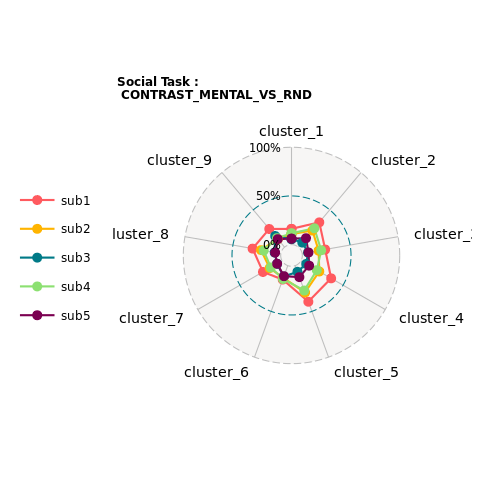

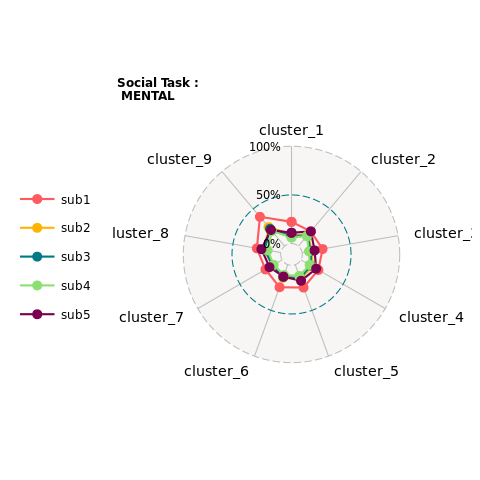

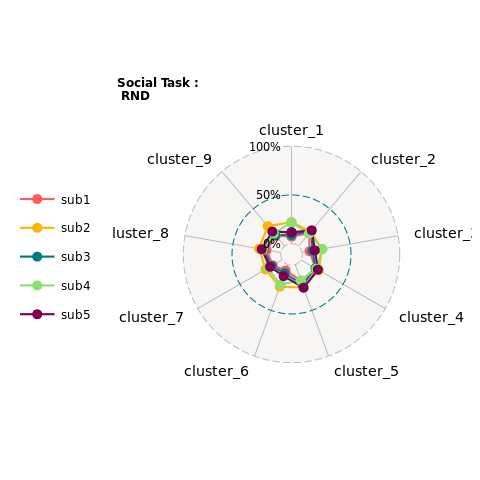

In [13]:
%%R -i path_root,list_trial
for (ii in list_trial) {
    MyData <- read.csv(file=paste(path_root,ii,"_r2.csv",sep = ''))
    # plot R2 radar plot
    image_radar=ggradar(MyData, 
                        grid.min = 0,
                        grid.mid = 0.05, 
                        grid.max = 0.1, 
                        axis.label.size = 5, 
                        grid.label.size = 5 ,
                        legend.text.size =5,
                        group.line.width = 1,
                        group.point.size = 4)  +
    theme(legend.text = element_text(size = 12),plot.title = element_text( face="bold",size = 12)) + 
    ggtitle(paste(' Social Task : \n  ',toupper(ii),sep = ''))
    print(image_radar)
    ggsave(file=paste(path_root,ii,"_R-squared.svg",sep = ''), plot=image_radar, width=10, height=8)
}

In [ ]:
# plot association wieght and phenotypes
for trial_name in list_trial :
    # build R2 table for radar plot
    for ix, pheno_name in enumerate(list_pheno):
        mat_file = os.path.join(path_association,pheno_name,'association_stats_{}.mat'.format(pheno_name))
        %octave_push mat_file
        %octave mat_load = load(mat_file);
        %octave_pull mat_load
        model_y =mat_load['model_raw']['y']
        model_x = mat_load['model_raw']['x']
        model_labels_x = mat_load['model_raw']['labels_x']
        model_labels_y = mat_load['model_raw']['labels_y']
        concat = [np.concatenate([model_y[x], model_x[x]]) for x in range(np.shape(model_y)[0])]
        model_df = pd.DataFrame(concat)
        model_df.index = model_labels_x
        colnames = np.concatenate([list_subtype,model_labels_y])
        model_df.columns = colnames
        model_df.to_csv(os.path.join(path_root,'{}_pheno_subtype.csv'.format(trial_name)))
        
        # plot association maps
        for subtype in list_subtype:
            fig = plt.figure(figsize=(9,16))
            ax1 = fig.add_subplot(511)
            ax1 = sns.regplot(x=pheno_name, y=subtype, data=model_df,color="#BCB6FF");
            ax1.set_ylabel('{}_{}'.format(trial_name,subtype))
            ax1.set_xlabel(pheno_name)